# AMS 520 Final Project

This notebook contains codes and report implementing 'Model high-frequency limit order book dynamics with SVM' written by Edward Cummings, Anton Malandii, Jack Peters, and Weiwei Tao.

In [1]:
import functools as fn

import pytz
import datetime
from datetime import datetime, timedelta
import math

import pandas as pd
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

# from sklearnex import patch_sklearn ## Must run patch before importing other sklearn functions!!!
# patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

ModuleNotFoundError: No module named 'sklearn'

## Part 1. Data Exploration

### Trade dataset

The trade dataset contains 243K UTP trade records from 14 different Stock Exchanges on 2022-01-06 between 4 a.m. until 8 p.m. EST for AAPL.

1. The trade prices varies from $292.75 to $314.61 while the trade volume varies from 1 to 1e6.
2. There are 5 different trading corrections: 00 = Regular trade, 1 - Original trade which was late corrected, 12 = Correction record, 08 = Original trade which was later cancelled, and 10 = Cancel record. More than 99% tredes were regular trade.
3. In the trade dataset, there are two time related variables available - Time and Participant timestamp. 

### Quote dataset
The quote dataset contains 473K UTP quote records from 13 different Stock Exchanges on 2022-01-06 for AAPL.

1. The quote dataset contains bid/offer prices and best bid/offer prices.
2. There are three different quote conditions: R = NBBO Regular, two-sided open quote, Y = NBBO Regular – One Sided Quote, and L = NBBO Closed Market Maker. More than 99% trades were regular two-sided open quote.

According to the data exploration, there are some outliers existing in the dataset. In the cleaned the dataset, we removed the outliers in the price and volume data, quote and trades didn't belong to regular condiitons.

In [2]:
def ts_to_pdts(ptimestamp, dte):
    """
    dte should be day of TAQ timestamp as datetime.datetime instance
    convert participant timestamp to time
    """
    str_zpad = str(ptimestamp).zfill(15)
    return pd.Timestamp(dte.year, dte.month, dte.day, int(str_zpad[:2]), int(str_zpad[2:4]), int(str_zpad[4:6]), 0, int(str_zpad[6:]))

day = datetime(2020,1,6)
pdts = fn.partial(ts_to_pdts, dte=day)

In [3]:
t = pd.read_csv('./query_trades_AAPL_20200106_born202210121745.csv',)

t['pdts'] = t['Participant_Timestamp'].apply(pdts)
t['minute'] = pd.to_datetime(t['pdts']).dt.strftime('%H:%M')
mintime = t['minute'].min()
maxtime = t['minute'].max()

print(f'There are {t.shape[0]} trades on Jan 6th.\n')
print(f'The minimum time is {mintime} and the max time is {maxtime} EST.\n')
print(f'The summary statistics for trade price and values can be seen below:\n')
t[['Trade_Volume', 'Trade_Price']].describe()

There are 242878 trades on Jan 6th.

The minimum time is 03:59 and the max time is 19:59 EST.

The summary statistics for trade price and values can be seen below:



,Trade_Volume,Trade_Price
count,2.428780e+05,242878.000000
mean,1.293561e+02,297.761787
std,3.760743e+03,1.721541
min,1.000000e+00,292.750000
25%,1.300000e+01,296.679525
50%,7.300000e+01,298.137400
75%,1.000000e+02,299.230000
max,1.115540e+06,314.611381


In [9]:
t.head()

,Time,Exchange,Symbol,Sale_Condition,Trade_Volume,Trade_Price,Trade_Stop_Stock_Indicator,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Source_of_Trade,Trade_Reporting_Facility,Participant_Timestamp,Trade_Reporting_Facility_TRF_Timestamp,Trade_Through_Exempt_Indicator,Date,YearMonth,pdts,minute,Trade_Correction_Levels
0,2020-01-06 04:00:00.064 -0500,P,AAPL,@ T,488,295.43,NaN,0,1192,1,N,,40000064303360,NaN,1,2020-01-05,202001,2020-01-06 03:59:59.999878851,03:59,Regular trade
1,2020-01-06 04:00:00.104 -0500,P,AAPL,@FT,100,295.26,NaN,0,1195,2,N,,40000103686400,NaN,1,2020-01-05,202001,2020-01-06 04:00:00.000607184,04:00,Regular trade
2,2020-01-06 04:00:00.104 -0500,P,AAPL,@FT,100,295.25,NaN,0,1196,3,N,,40000103686400,NaN,1,2020-01-05,202001,2020-01-06 04:00:00.000607184,04:00,Regular trade
3,2020-01-06 04:00:00.197 -0500,P,AAPL,@FTI,25,295.12,NaN,0,1198,4,N,,40000197144064,NaN,1,2020-01-05,202001,2020-01-06 03:59:59.999575569,03:59,Regular trade
4,2020-01-06 04:00:00.197 -0500,P,AAPL,@FTI,1,295.08,NaN,0,1199,5,N,,40000197144064,NaN,1,2020-01-05,202001,2020-01-06 03:59:59.999575569,03:59,Regular trade


In [4]:
cols = ['Symbol', 'Source_of_Trade', 'Exchange', 'Sale_Condition', 'Trade_Correction_Indicator']
for col in cols:
    print(col, '(Nunique=',t[col].nunique() ,'): ',t[col].unique())

Symbol (Nunique= 1 ):  ['AAPL']
Source_of_Trade (Nunique= 1 ):  ['N']
Exchange (Nunique= 14 ):  ['P' 'Q' 'K' 'J' 'Z' 'Y' 'D' 'B' 'N' 'X' 'C' 'M' 'V' 'A']
Sale_Condition (Nunique= 30 ):  ['@ T ' '@FT ' '@FTI' '@ TI' 'N T ' 'C TI' '@   ' '@F I' '@  I' '@  Q'
 '@F  ' '@O X' '@4  ' '@7 V' '@4 I' '@ ZI' '@ Z ' 'N  I' '@7 I' 'C  I'
 'N   ' '@4 W' '@7  ' 'C   ' '@  W' '@  M' '@6 X' '@ TW' '@ TP' '@ UW']
Trade_Correction_Indicator (Nunique= 5 ):  [ 0  8 10  1 12]


In [5]:
print('The distribution of trade correction is as:\n')
t['Trade_Correction_Levels'] = t['Trade_Correction_Indicator'].replace({0: 'Regular trade', 8: 'Original trade which was later cancelled', 10: 'Cancel record', 1: 'Original trade which was late corrected', 12: 'Correction record'})
t['Trade_Correction_Levels'].value_counts(normalize = True)

The distribution of trade correction is as:



Regular trade                               0.999942
Original trade which was later cancelled    0.000025
Cancel record                               0.000025
Original trade which was late corrected     0.000004
Correction record                           0.000004
Name: Trade_Correction_Levels, dtype: float64

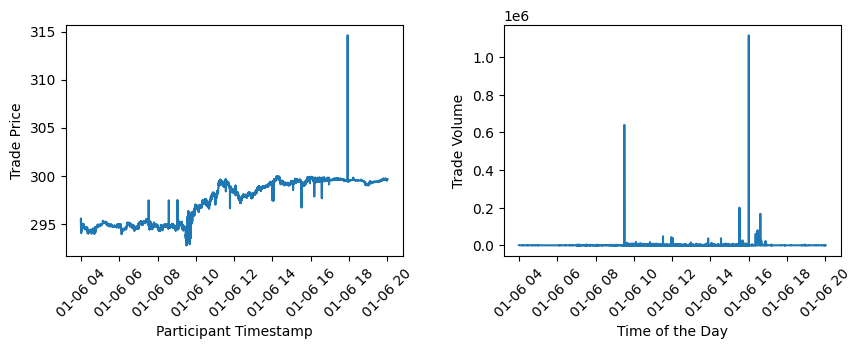

In [10]:
t1 = t.sort_values(['Participant_Timestamp'])
fig = plt.figure(figsize=(10, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(t1['pdts'], t1['Trade_Price'])
ax1.set_xlabel('Time of the Day')
ax1.set_ylabel('Trade Price')
ax1.tick_params(axis='x', labelrotation=45)

ax2.plot(t1['pdts'], t1['Trade_Volume'])
ax2.set_xlabel('Time of the Day')
ax2.set_ylabel('Trade Volume')
#ax2.set_yscale('log')
ax2.tick_params(axis='x', labelrotation=45)

plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

In [3]:
q.columns

Index(['Time', 'Exchange', 'Symbol', 'Bid_Price', 'Bid_Size', 'Offer_Price',
       'Offer_Size', 'Quote_Condition', 'Sequence_Number',
       'FINRA_BBO_Indicator', 'FINRA_ADF_MPID_Indicator', 'Source_Of_Quote',
       'Best Bid Quote Condition', 'Best_Bid_Exchange', 'Best_Bid_Price',
       'Best_Bid_Size', 'Best_Bid_FINRA_Market_Maker_ID',
       'Best_Offer_Quote_Condition', 'Best_Offer_Exchange', 'Best_Offer_Price',
       'Best_Offer_Size', 'Best_Offer_FINRA_Market_Maker_ID', 'LULD_Indicator',
       'LULD_NBBO_Indicator', 'SIP_Generated_Message_Identifier',
       'Participant_Timestamp', 'FINRA_ADF_Timestamp',
       'Security_Status_Indicator', 'National_BBO_Ind',
       'Quote_Cancel_Correction', 'Effective_Date'],
      dtype='object')

In [8]:
q = pd.read_csv('./query_quotes_AAPL_20200106_born202210121744.csv',)
pd.set_option('display.max_columns', None)
q['pdts'] = q['Participant_Timestamp'].apply(pdts)
q['minute'] = pd.to_datetime(q['pdts']).dt.strftime('%H:%M')
mintime = q['minute'].min()
maxtime = q['minute'].max()

print(f'There are {q.shape[0]} quotes records on Jan 6th.\n')
print(f'The summary statistics for trade price and values can be seen below:\n')
print(f'The minimum time is {mintime} and the max time is {maxtime} EST.\n')

q[['Bid_Price', 'Bid_Size', 'Offer_Price', 'Offer_Size', 'Best_Bid_Price', 'Best_Bid_Size', 'Best_Offer_Price', 'Best_Offer_Size']].describe()

There are 473340 quotes records on Jan 6th.

The summary statistics for trade price and values can be seen below:

The minimum time is 04:00 and the max time is 19:59 EST.



,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Best_Bid_Price,Best_Bid_Size,Best_Offer_Price,Best_Offer_Size
count,473340.000000,473340.000000,473340.000000,473340.000000,473340.000000,473340.000000,473340.000000,473340.000000
mean,297.274051,2.766567,296.825995,2.883602,297.960107,3.055586,297.986993,3.419732
std,13.658325,6.592357,18.846965,7.292170,1.463209,4.592779,1.575978,9.353743
min,0.000000,0.000000,0.000000,0.000000,278.000000,1.000000,0.000000,0.000000
25%,296.900000,1.000000,296.980000,1.000000,296.950000,1.000000,296.980000,1.000000
50%,298.150000,2.000000,298.190000,2.000000,298.170000,2.000000,298.190000,2.000000
75%,299.200000,3.000000,299.240000,3.000000,299.210000,4.000000,299.230000,4.000000
max,299.950000,203.000000,307.870000,440.000000,299.950000,203.000000,299.960000,440.000000


In [91]:
cols = ['Symbol', 'Quote_Condition', 'Exchange', 'Source_Of_Quote', 'Best_Bid_Exchange',  'Best_Offer_Exchange', 'National_BBO_Ind']
for col in cols:
    print(col, '(Nunique=',q[col].nunique() ,'): ',q[col].unique())

Symbol (Nunique= 1 ):  ['AAPL']
Quote_Condition (Nunique= 3 ):  ['R' 'Y' 'L']
Exchange (Nunique= 13 ):  ['Z' 'N' 'P' 'X' 'Q' 'A' 'K' 'B' 'C' 'M' 'Y' 'V' 'J']
Source_Of_Quote (Nunique= 1 ):  ['N']
Best_Bid_Exchange (Nunique= 13 ):  ['Q' 'P' 'Z' 'N' 'Y' 'J' 'K' 'X' 'M' 'V' 'B' 'C' 'A']
Best_Offer_Exchange (Nunique= 13 ):  ['V' 'Z' 'N' 'P' 'K' 'Q' 'Y' 'J' 'X' 'M' 'B' 'C' 'A' nan]
National_BBO_Ind (Nunique= 1 ):  [2]


In [92]:
print('The distribution of quote conditions are as:\n')
q['Quote_Condition_levels'] = q['Quote_Condition'].replace({'R': 'NBBO Regular, two-sided open quote', 'Y': 'NBBO Regular – One Sided Quote', 'L': 'NBBO Closed Market Maker'})
q['Quote_Condition_levels'].value_counts(normalize=True)

The distribution of quote conditions are as:



NBBO Regular, two-sided open quote    0.999894
NBBO Regular – One Sided Quote        0.000072
NBBO Closed Market Maker              0.000034
Name: Quote_Condition_levels, dtype: float64

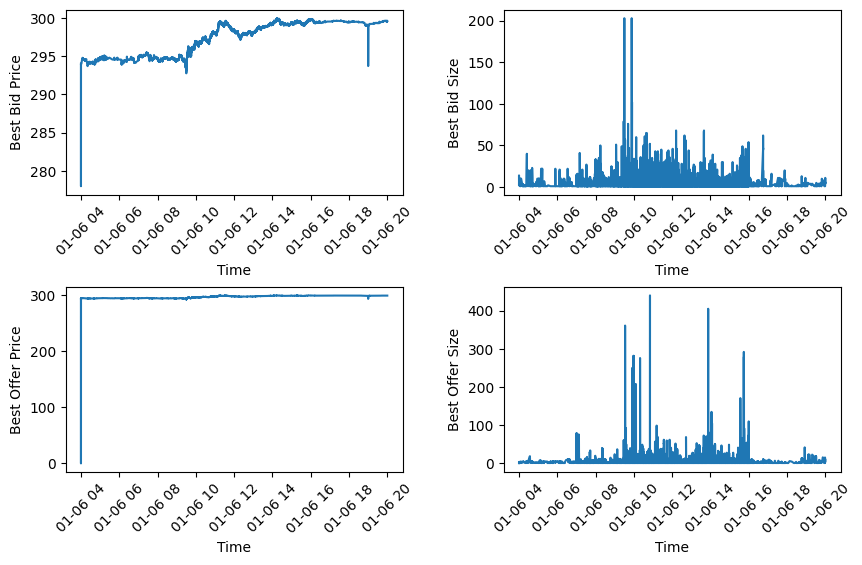

In [93]:
q1 = q.sort_values(['pdts'])
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.plot(q1['pdts'], q1['Best_Bid_Price'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Best Bid Price')
ax1.tick_params(axis='x', labelrotation=45)

ax2.plot(q1['pdts'], q1['Best_Bid_Size'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Best Bid Size')
ax2.tick_params(axis='x', labelrotation=45)

ax3.plot(q1['pdts'], q1['Best_Offer_Price'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Best Offer Price')
ax3.tick_params(axis='x', labelrotation=45)

ax4.plot(q1['pdts'], q1['Best_Offer_Size'])
ax4.set_xlabel('Time')
ax4.set_ylabel('Best Offer Size')
ax4.tick_params(axis='x', labelrotation=45)

plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

In [112]:
## the final dataset remove outliers in the price and volume data, quotes and trades from exchange Q
## quote and trades didn't belong to regular type
q1 = q.loc[ (q['Best_Offer_Price'] > 200) & (q['Best_Bid_Price'] > 250) &(q['Quote_Condition'] == 'R') ]
t1 = t.loc[ (t['Trade_Price'] < 305) & (t['Trade_Volume'] < 5e5) &(t['Trade_Correction_Indicator'] == 0) ]
print('The shape of final quote dataset is ', q1.shape)
print('The shape of final trade dataset is ', t1.shape)

The shape of final quote dataset is  (473288, 34)
The shape of final trade dataset is  (242859, 20)


## Part 2. Data Clean Up

To clean up the dataset, we first worked on regrouping those trades and quote updates that stem from the same marketable order execution. We used the participant timestamp to assign a unique marketable order execution (MOX) identifier to each batch of trades and quotes triggered in execution of a single marketable order.
 
We can use the participant timestamp to derive the MOX identifier because all trades and quote updates that are triggered in the execution of the same marketable order receive the same participant (but not SIP) timestamp in high resolution (microseconds to nanoseconds, respectively one millionth and one billionth of a second) per exchange-stock-day.


The raw_tq2mox function trims the first/last 15 minutes of normal trading hours and added MOX identifier and LAQ (Last active quote) to the original dataset.

In [10]:
def ts_to_secs(ptimestamp):
    str_zpad = str(ptimestamp).zfill(15)
    return int(str_zpad[:2])*3600 + int(str_zpad[2:4])*60 + int(str_zpad[4:6]) + 1e-9 *float(str_zpad[6:])


def raw_tq2mox(t, q):
    """
    Modifies raw quote and trade data. Trims the first and last 15 minutes 
    of normal trading hours. Adds MOX identifier and LAQ (Last active quote).

    Parameters:
    -------------
    t : pd.DataFrame
        raw TAQ trades dataframe from csv
    q : pd.DataFrame
        raw TAQ quotes dataframe from csv
        
    Returns:
    ---------

    t_v : pd.DataFrame
        cleaned trades with MOX id, LAQ
    q_v : pd.DataFrame
        cleaned quotes with MOX id
    """
    t.sort_values(by=['Participant_Timestamp','Sequence_Number'], axis=0, inplace=True)
    q.sort_values(by=['Participant_Timestamp','Sequence_Number'],axis=0, inplace=True )
    t_v = t[np.logical_and(t['Participant_Timestamp'] >= 94500000000000, t['Participant_Timestamp'] <= 154500000000000) ] # remove closing/opening auction dissemination ( remove first and last 15 min), formally->3:50pm NYSE/NASDAQ (closing cross)
    q_v = q[np.logical_and(q['Participant_Timestamp'] >= 94500000000000, q['Participant_Timestamp'] <= 154500000000000) ] # 
    # t_v = t[np.logical_and(t['Participant_Timestamp'] >= 93000000000000,t['Participant_Timestamp'] <= 100000000000000) ] # smaller size, testing opening cross' influence
    # q_v = q[np.logical_and(q['Participant_Timestamp'] >= 93000000000000,q['Participant_Timestamp'] <= 100000000000000) ]
    t_v['pt_secs'] = t_v['Participant_Timestamp'].apply(ts_to_secs)
    q_v['pt_secs'] = q_v['Participant_Timestamp'].apply(ts_to_secs)

    ### Assigning MOX to trades and quotes
    mox = 1 # MOX of zero saved for exchange updated quotes versus MQUs
    j = 0 
    N = len(t_v)
    t_v['MOX'] = np.full(N, np.nan, dtype=int)
    while j < N:
        cur_pts = t_v['Participant_Timestamp'].iloc[j]
        while j < N and cur_pts == t_v['Participant_Timestamp'].iloc[j]:
            t_v['MOX'].iloc[j] = mox
            j +=1
        mox += 1
        
    # MOX of zero saved for exchange updated quotes versus MQUs
    j = 0 
    N = len(q_v)
    q_v['MOX'] = np.full(N, np.nan,dtype=int)
    while j < N:
        cur_pts = q_v['pt_secs'].iloc[j]
        df_trade_moxes = t_v[t_v['pt_secs'] == cur_pts]
        # if cur_pts == 34518.935274496:
        #     pdb.set_trace()
        if len(df_trade_moxes) == 0 or len(df_trade_moxes) == 1: # MQU with only 1 trade/quote update
            q_v['MOX'].iloc[j] = 0
        else:
            #pdb.set_trace()
            q_v['MOX'].iloc[j] = df_trade_moxes['MOX'].iloc[0]
        j +=1
        
    t_v['LAQ_bid'] = np.zeros(len(t_v))
    t_v['LAQ_offer'] = np.zeros(len(t_v))
    t_v['LAQ_pt'] = np.zeros(len(t_v))
    t_v['LAQ_bid_size'] = np.zeros(len(t_v))
    t_v['LAQ_offer_size'] = np.zeros(len(t_v))
    
    ## mask for last MQU or natural quotes only
    mask_natural = (q_v['MOX'] == 0).to_numpy()
    mask_lastmqu = np.concatenate(([True], mask_natural[1:]))
    mask_valid_LAQ = np.logical_or(mask_natural, mask_lastmqu)
    q_valid_LAQ = q_v.iloc[mask_valid_LAQ,:]
    for i in t_v.index.to_numpy():
        cur_pt = t_v['pt_secs'].loc[i]

        try:
            vquotes = q_valid_LAQ[np.logical_and(q_valid_LAQ['pt_secs'] >= cur_pt - 0.1, q_valid_LAQ['pt_secs'] <= cur_pt )].iloc[-1]
            t_v['LAQ_bid'].loc[i] = vquotes['Best_Bid_Price'] 
            t_v['LAQ_offer'].loc[i] = vquotes['Best_Offer_Price']  
            t_v['LAQ_bid_size'].loc[i] = vquotes['Best_Bid_Size'] 
            t_v['LAQ_offer_size'].loc[i] = vquotes['Best_Offer_Size']  
            t_v['LAQ_pt'].loc[i] = vquotes['pt_secs'] 
        except:
            t_v['LAQ_bid'].loc[i] = np.nan
            t_v['LAQ_offer'].loc[i] = np.nan 
            t_v['LAQ_pt'].loc[i] = np.nan
            t_v['LAQ_bid_size'].loc[i] =np.nan
            t_v['LAQ_offer_size'].loc[i] = np.nan
    return t_v, q_v

In [11]:
t_v0, q_v0 = raw_tq2mox(t, q) # Slow, naive mox fitting - need to make this code faster. Took 15 minutes on laptop.

## Part III. Feature Generation

In [102]:
q_v = q_v0.drop(columns = ['FINRA_BBO_Indicator', 'FINRA_ADF_MPID_Indicator', 'Source_Of_Quote', 'Best Bid Quote Condition',
'Best_Bid_Exchange', 'Best_Bid_FINRA_Market_Maker_ID', 'Best_Offer_Quote_Condition', 'Best_Offer_Exchange', 'Best_Offer_FINRA_Market_Maker_ID',
'LULD_Indicator', 'LULD_NBBO_Indicator', 'SIP_Generated_Message_Identifier', 'FINRA_ADF_Timestamp', 'National_BBO_Ind', 'Security_Status_Indicator', 'Quote_Cancel_Correction', 'Effective_Date'])
t_v = t_v0.drop(columns = ['Sale_Condition', 'Trade_Stop_Stock_Indicator', 'Trade_Id',
       'Source_of_Trade', 'Trade_Reporting_Facility', 'Trade_Reporting_Facility_TRF_Timestamp',
       'Trade_Through_Exempt_Indicator', 'Date', 'YearMonth' ] )

## delta t
num_events=30

In [103]:
print("The quote dataset: ", q_v.columns)
print("The trade dataset: ", t_v.columns)

The quote dataset:  Index(['Time', 'Exchange', 'Symbol', 'Bid_Price', 'Bid_Size', 'Offer_Price',
       'Offer_Size', 'Quote_Condition', 'Sequence_Number', 'Best_Bid_Price',
       'Best_Bid_Size', 'Best_Offer_Price', 'Best_Offer_Size',
       'Participant_Timestamp', 'pt_secs', 'MOX'],
      dtype='object')
The trade dataset:  Index(['Time', 'Exchange', 'Symbol', 'Trade_Volume', 'Trade_Price',
       'Trade_Correction_Indicator', 'Sequence_Number',
       'Participant_Timestamp', 'pt_secs', 'MOX', 'LAQ_bid', 'LAQ_offer',
       'LAQ_pt', 'LAQ_bid_size', 'LAQ_offer_size'],
      dtype='object')


In [75]:
day = datetime(2020,1,6)
pdts = fn.partial(ts_to_pdts, dte=day)
q_v['pdts'] = q_v['Participant_Timestamp'].apply(pdts)
q_v.set_index('pdts', inplace=True)
q_v.sort_index(inplace=True)

## time sensitive set
q_v['dPbid'] = q_v['Best_Bid_Price'].diff()
q_v['dPask'] = q_v['Best_Offer_Price'].diff()
q_v['dVbid'] = q_v['Best_Bid_Size'].diff()
q_v['dVask'] = q_v['Best_Offer_Size'].diff()
q_v[['ddPbid','ddPask','ddVbid','ddVask']] = q_v[['dPbid','dPask','dVbid','dVask']].rolling('1s').sum()

In [76]:
### find out all trade prices and volumes
## all quote records
q_v_temp = pd.DataFrame({'id': q_v['Sequence_Number'].to_numpy(),
                        'tvolume': np.zeros(len(q_v)),
                        'tprice': np.zeros(len(q_v)), 
                            'Participant_Timestamp': q_v['Participant_Timestamp'].to_numpy(),
                            'is_trade': np.zeros(len(q_v))}
                    )

## all quote records
t_v_temp = pd.DataFrame({'id': t_v['Sequence_Number'].to_numpy(),
                        'tvolume': t_v['Trade_Volume'].to_numpy(),
                        'tprice': t_v['Trade_Price'].to_numpy(), 
                            'Participant_Timestamp': t_v['Participant_Timestamp'].to_numpy(),
                            'is_trade': np.ones(len(t_v))}

                    )
df_trade_features = pd.concat([q_v_temp, t_v_temp], axis = 0)

df_trade_features['pdts'] = df_trade_features['Participant_Timestamp'].astype(np.int64).apply(pdts)
df_trade_features.set_index('pdts', inplace=True)
df_trade_features.sort_index(inplace=True)

df_trade_features[['avg_trade_price_10ms','avg_trade_volume_10ms']] = df_trade_features[['tprice','tvolume']].rolling('10ms').mean()
df_trade_features[['avg_trade_price_100ms','avg_trade_volume_100ms']] = df_trade_features[['tprice','tvolume']].rolling('100ms').mean()
df_trade_features[['avg_trade_price_1s','avg_trade_volume_1s']] = df_trade_features[['tprice','tvolume']].rolling('1s').mean()
df_trade_features[['avg_trade_price_10s','avg_trade_volume_10s']] = df_trade_features[['tprice','tvolume']].rolling('10s').mean()

In [104]:
## trade related features
q_v_update = df_trade_features.loc[df_trade_features['is_trade'] == 0]
q_v_update.reset_index(inplace=True)
q_v_update.set_index('id',inplace=True)
q_v_update.sort_index(inplace=True)

q_v.reset_index(inplace = True)
q_v.set_index('Sequence_Number', inplace=True)
q_v.sort_index(inplace=True)

q_v[['avg_trade_price_1s','avg_trade_volume_1s', 'avg_trade_price_10s','avg_trade_volume_10s' ]] = np.zeros((len(q_v), 4))
q_v.loc[q_v_update.index.to_numpy(),
    ['avg_trade_price_10ms','avg_trade_volume_10ms',
    'avg_trade_price_100ms','avg_trade_volume_100ms',
    'avg_trade_price_1s','avg_trade_volume_1s',
    'avg_trade_price_10s','avg_trade_volume_10s' ]]  = q_v_update[['avg_trade_price_100ms','avg_trade_volume_100ms', 'avg_trade_price_10ms','avg_trade_volume_10ms', 
                                                                    'avg_trade_price_1s','avg_trade_volume_1s', 'avg_trade_price_10s','avg_trade_volume_10s']].to_numpy()

q_v['Sequence_Number'] = q_v.index.to_numpy()
q_v.sort_values('pt_secs',inplace=True)

mask_natural = (q_v['MOX'] == 0).to_numpy()
mask_lastmqu = np.concatenate(([True], mask_natural[1:]))
mask_valid_LAQ = np.logical_or(mask_natural, mask_lastmqu)

q_valid_LAQ = q_v.iloc[mask_valid_LAQ,:]
q_valid_LAQ['Best_Mid_Price'] = (q_valid_LAQ['Best_Bid_Price'] + q_valid_LAQ['Best_Offer_Price'])/2.0

In [106]:
### outcomes
mids = q_valid_LAQ['Best_Mid_Price'].to_numpy()
bids = q_valid_LAQ['Best_Bid_Price'].to_numpy()
asks = q_valid_LAQ['Best_Offer_Price'].to_numpy()

y_mid = []
y_spread = []
for i in range(num_events, len(mids)):
    if mids[i] > mids[i - num_events]:
        y_mid.append('Up')
    elif mids[i] == mids[i - num_events]:
        y_mid.append('Stationary')
    else:
        y_mid.append('Down')

    if bids[i] > asks[i - num_events]:
        y_spread.append('Up')
    elif bids[i] == asks[i - num_events]:
        y_spread.append('Stationary')
    else:
        y_spread.append('Down')

In [110]:
from collections import Counter
print(Counter(y_mid))
print(Counter(y_spread))

Counter({'Up': 177806, 'Down': 164885, 'Stationary': 45223})
Counter({'Down': 323316, 'Stationary': 37880, 'Up': 26718})


In [67]:
## Features - first pass
## price and volume
ask_price = asks[:-num_events]
bid_price = bids[:-num_events]
ask_volume = q_valid_LAQ['Best_Offer_Size'].to_numpy()[:-num_events]
bid_volume = q_valid_LAQ['Best_Bid_Size'].to_numpy()[:-num_events]

# spreads, first level only
mid_price = mids[:-num_events]
spread =ask_price - bid_price

# derivatives, averaged over last t seconds
ddPask_dt = np.nan_to_num(q_valid_LAQ['ddPask'][:-num_events].to_numpy())
ddPbid_dt = np.nan_to_num(q_valid_LAQ['ddPbid'][:-num_events].to_numpy())
ddVask_dt = np.nan_to_num(q_valid_LAQ['ddVask'][:-num_events].to_numpy())
ddVbid_dt = np.nan_to_num(q_valid_LAQ['ddVbid'][:-num_events].to_numpy())

# trade-based features
avg_trade_price_10ms   =  q_valid_LAQ['avg_trade_price_10ms'][:-num_events].to_numpy()
avg_trade_price_100ms  =  q_valid_LAQ['avg_trade_price_100ms'][:-num_events].to_numpy()
avg_trade_volume_10ms  =  q_valid_LAQ['avg_trade_volume_10ms'][:-num_events].to_numpy()
avg_trade_volume_100ms =  q_valid_LAQ['avg_trade_volume_100ms'][:-num_events].to_numpy()

avg_trade_price_1s   =  q_valid_LAQ['avg_trade_price_1s'][:-num_events].to_numpy()
avg_trade_price_10s  =  q_valid_LAQ['avg_trade_price_10s'][:-num_events].to_numpy()
avg_trade_volume_1s  =  q_valid_LAQ['avg_trade_volume_1s'][:-num_events].to_numpy()
avg_trade_volume_10s =  q_valid_LAQ['avg_trade_volume_10s'][:-num_events].to_numpy()

time = q_valid_LAQ['pt_secs'].to_numpy()[:-num_events]

dict_data = {
        'time'      : time,
        'y_mid'     : y_mid,
        'y_spread'  : y_spread,
        
        'ask_price' : ask_price,
        'bid_price' : bid_price,
        'ask_volume': ask_volume,
        'bid_volume': bid_volume,

        'mid_price' : (ask_price + bid_price) / 2.0,
        'spread'    : ask_price - bid_price,

        'dPask_dt'  : ddPask_dt,
        'dPbid_dt'  : ddPbid_dt,
        'dVask_dt'  : ddVask_dt,
        'dVbid_dt'  : ddVbid_dt,
        
        'avg_trade_price_10ms'   : avg_trade_price_10ms,
        'avg_trade_price_100ms'  :  avg_trade_price_100ms,
        'avg_trade_price_1s'   : avg_trade_price_1s,
        'avg_trade_price_10s'  :  avg_trade_price_10s,

        'avg_trade_volume_10ms'  :  avg_trade_volume_10ms,
        'avg_trade_volume_100ms' :  avg_trade_volume_100ms,
        'avg_trade_volume_1s'  :  avg_trade_volume_1s,
        'avg_trade_volume_10s' :  avg_trade_volume_10s,
        }

df_clean = pd.DataFrame(data=dict_data)


## Part IV. Train SVM Model

In [49]:
#### use predict set {-1, 1}
#df_clean = pd.read_feather('clean_features_221105_trades_ddt.f')
split  = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3407)
n = 10000
ind_select =  np.random.choice(np.arange(len(df_clean)),size=n)
df_select = df_clean.iloc[ind_select,:]
for train_index, test_index in split.split(df_select, df_select['spreadup']):
    train_set = df_clean[:n].loc[train_index]
    test_set = df_clean[:n].loc[test_index]

y_train = np.where(np.array(train_set['spreadup']), -1.0, 1.0)

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=2, C=0.25, gamma=1.0, coef0=1.0, verbose=True)) # adjusting gamma for increased smoothness - trying to avoid trivial prediction
])
svm.fit(train_set[['ask_price', 'bid_price', 'ask_volume', 'bid_volume', 
                   'mid_price', 'spread', 
                   'dPask_dt', 'dPbid_dt', 'dVbid_dt', 'dVask_dt',
                   'avg_trade_price_10ms','avg_trade_volume_10ms',
                   'avg_trade_price_100ms','avg_trade_volume_100ms',
                   'avg_trade_price_1s','avg_trade_volume_1s',
                   'avg_trade_price_10s','avg_trade_volume_10s' 
                  ]], 
        y_train
        )

[LibSVM]

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=0.25, coef0=1.0, degree=2, gamma=1.0, kernel='poly',
                     verbose=True))])

In [50]:
svm_predict = svm.predict(test_set[[
                   'ask_price', 'bid_price', 'ask_volume', 'bid_volume', 
                   'mid_price', 'spread', 
                   'dPask_dt', 'dPbid_dt', 'dVbid_dt', 'dVask_dt',
                   'avg_trade_price_10ms','avg_trade_volume_10ms',
                   'avg_trade_price_100ms','avg_trade_volume_100ms',
                   'avg_trade_price_1s','avg_trade_volume_1s',
                   'avg_trade_price_10s','avg_trade_volume_10s' 
                  ]])
y_test = np.where(np.array(test_set['spreadup']), -1.0, 1.0)
print(confusion_matrix(y_test, svm_predict))
print(classification_report(y_test, svm_predict))

[[  36  779]
 [  24 1161]]
              precision    recall  f1-score   support

        -1.0       0.60      0.04      0.08       815
         1.0       0.60      0.98      0.74      1185

    accuracy                           0.60      2000
   macro avg       0.60      0.51      0.41      2000
weighted avg       0.60      0.60      0.47      2000



In [51]:
train_set['spreadup'].value_counts()/len(y_train)

False    0.578625
True     0.421375
Name: spreadup, dtype: float64